In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr, f_oneway
from scipy.stats import ttest_ind
import plotly.express as px
from statsmodels.stats.multicomp import pairwise_tukeyhsd



### PART1 1. Read in the gapminder_clean.csv data as a pandas DataFrame (df).

In [28]:
# Read in the country stats data as a .csv.
country_stats_df = pd.read_csv("gapminder_clean.csv", index_col=0)


### PART1 2. Filter the data to include only rows where Year is 1962 and then make a scatter plot comparing 'CO2 emissions (metric tons per capita)' and gdpPercap for the filtered data.

Text(0.5, 1.0, 'Country data in 1962\n comparing CO2 emissions with GDP per capita')

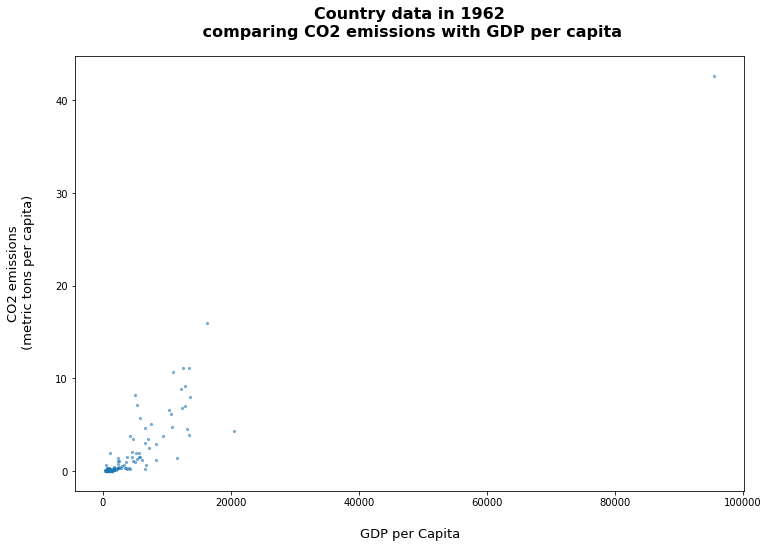

In [75]:
# Filter the df to only include rows in which 'Year' equals 1962.
df_1962 = country_stats_df[country_stats_df['Year'] == 1962] 

# Create scatterplot.
# Use s and alpha to adjust scatter point size and transparency.
df_1962.plot.scatter(x='gdpPercap', y='CO2 emissions (metric tons per capita)', s=5, alpha=0.5, figsize=(12, 8))
plt.xlabel('GDP per Capita', fontsize=13, labelpad=20)
plt.ylabel('CO2 emissions\n (metric tons per capita)', fontsize=13, labelpad=20)
plt.title('Country data in 1962\n comparing CO2 emissions with GDP per capita', pad=20, fontsize=16, fontweight='bold')

The above graph appears to contain an error. The clear outlier here is Kuwait, with an apparent GDP per capita of 95458 (presumably USD) in 1962. This is far higher than the World Bank's estimate (approx. 5000).


In [31]:
# Confirmation that Kuwait is the outlier in the above graph.
df_1962.loc[df_1962['gdpPercap'].idxmax()]

Country Name                                                Kuwait
Year                                                          1962
Agriculture, value added (% of GDP)                            NaN
CO2 emissions (metric tons per capita)                     42.6371
Domestic credit provided by financial sector (% of GDP)        NaN
Electric power consumption (kWh per capita)                    NaN
Energy use (kg of oil equivalent per capita)                   NaN
Exports of goods and services (% of GDP)                       NaN
Fertility rate, total (births per woman)                     7.302
GDP growth (annual %)                                          NaN
Imports of goods and services (% of GDP)                       NaN
Industry, value added (% of GDP)                               NaN
Inflation, GDP deflator (annual %)                             NaN
Life expectancy at birth, total (years)                    61.8485
Population density (people per sq. km of land area)        18.

### PART1 3. On the filtered data, calculate the pearson correlation of 'CO2 emissions (metric tons per capita)' and gdpPercap. What is the Pearson R value and associated p value?

In [32]:
# Note here this .corr returns same value as when the columns have na removed prior with .dropna.
# .corr also appears to be unaffected regardless of whether 1 or both values are missing from an x,y datapoint.
pearson_r = df_1962['gdpPercap'].corr(df_1962['CO2 emissions (metric tons per capita)'])
pearson_r

0.9260816725019452

In [76]:
# Define a simple function to return the R and P values of the Pearson correlation as a tuple. 
def pearsonr_pval(x,y):
        return pearsonr(x,y)[0], pearsonr(x,y)[1]

# use .corr and the function defined above as the method.
corr = df_1962['gdpPercap'].corr(df_1962['CO2 emissions (metric tons per capita)'], method=pearsonr_pval)
print('R value: %f,  P value: %.010f' % (corr[0], corr[1]))


R value: 0.926082,  P value: 0.0000000000


Above cell shows the Pearson R value and P value for the correlation between GDP per capita and CO2 emissions for the year 1962.


### PART1 4. On the unfiltered data, answer "In what year is the correlation between 'CO2 emissions (metric tons per capita)' and gdpPercap the strongest?" Filter the dataset to that year for the next step...

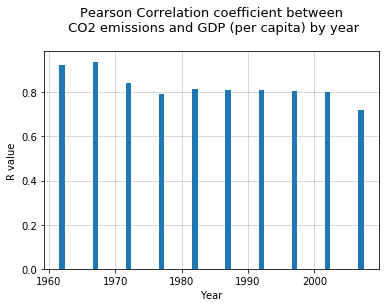

In [78]:
# Obtain unique years within the df (using set) to be iterated over.
years = list(set(country_stats_df['Year']))

# Define an empty dictionary to be filled with years and corresponding R values. 
co2_gdp_correlation_by_year = {}

# Iterate over each year and calculate the Pearson correlation coefficient for GDP per capita and CO2 emissions for each.
for year in years:
    year_df = country_stats_df[country_stats_df['Year'] == year]
    corr = year_df['gdpPercap'].corr(year_df['CO2 emissions (metric tons per capita)'], method = pearsonr_pval)
    
    # Append year and corresponding R value to dictionary.
    co2_gdp_correlation_by_year[year] = corr[0]


# Make ordered list of tuples from the dictionary.
# unpack tuples with *.
tuples_co2_gdp_correlation_by_year = sorted(co2_gdp_correlation_by_year.items())
x, y = zip(*tuples_co2_gdp_correlation_by_year)

# Create a bar chart to visualise each year's R value.
plt.bar(x, y)
plt.xlabel('Year')
plt.ylabel('R value')
plt.title('Pearson Correlation coefficient between\n CO2 emissions and GDP (per capita) by year', fontsize=13, pad=20)
plt.grid(b=True, which='both', axis='both', linewidth=0.5)
ax = plt.gca()
ax.set_axisbelow(True)

plt.show()


In [35]:
max(co2_gdp_correlation_by_year.keys(), key=(lambda k: co2_gdp_correlation_by_year[k]))

1967

The above code returns the year whose corresponding correlation coefficient is greatest, as can also be seen in the above visualisation.

### PART1 5. Using plotly or bokeh, create an interactive scatter plot comparing 'CO2 emissions (metric tons per capita)' and gdpPercap where the point size is determined by pop (population) and the color is determined by the continent

In [83]:
# Filter the df to the year with the largest R value as determined above - 1967.
df_1967 = country_stats_df[country_stats_df['Year'] == 1967]

# Drop all rows that are missing at least one datapoint from the specified subset of columns in the df.
df_1967 = df_1967.dropna(subset=['gdpPercap', 'CO2 emissions (metric tons per capita)', 'continent', 'pop'])

# Create a plotly scatter plot (px is how plotly.express has been imported).
# Customise the data visible when mouse-hovering using the hover_data parameter.
fig1 = px.scatter(df_1967, x='gdpPercap', y='CO2 emissions (metric tons per capita)', color='continent', size='pop', hover_data=['Country Name'], title='1967 country GDP per capita vs CO2 emissions per capita')
fig1.update_layout(title_font_size=16, title_x=0.5, xaxis_title = 'GDP per capita')

fig1.show()

In the above graph GDP per capita is compared with CO2 emissions per capita. Countries with greater populations are indicated by larger circles.

### PART2 1. What is the relationship between continent and 'Energy use (kg of oil equivalent per capita)'? (Stats test needed)

In [81]:
# Use one-way ANOVA to calc if there is a sig. difference between energy use (measurement) based on continents (categorical).
# A Tukey HSD (Honestly Significant Difference) test can be used to determine significance between particular groups.

# Obtain list of unique continents to iterate over.
continents = list(set(country_stats_df['continent']))
continent_energy_use_dict = {}

# Access the dataframe at each continent.
for continent in continents:

    # Access energy use specifically.
    # Remove nans with .dropna() (else f_oneway() will not compute successfully).
    energy_use_array = country_stats_df[country_stats_df['continent'] == continent] \
    ['Energy use (kg of oil equivalent per capita)'].dropna()

    # Append continent and corresponding energy use array.
    # Convert Series to list for use in f_oneway().
    continent_energy_use_dict[continent] = energy_use_array.tolist()



In [38]:
# Each continent key in the dictionary corresponds to an array of values for that continent's energy use data.
# These are computed together in the f_oneway (ANOVA), to compare the means of the different groups.
f_oneway(continent_energy_use_dict['Africa'], continent_energy_use_dict['Americas'], continent_energy_use_dict['Asia'], continent_energy_use_dict['Europe'], continent_energy_use_dict['Oceania'])

F_onewayResult(statistic=51.45915759042634, pvalue=8.527003487154367e-39)

The above ANOVA identifies a significant difference in the energy use per capita of different continents. The F-statistic is the ratio of variance among the means of different groups versus the variance within samples. This, and the accompanying P value, indicate that there is a significant difference in the energy usage of different continents. The post-hoc Tukey HSD test can be applied to identify specific relationships (see below).

In [39]:
# Return df only with rows in which energy use's value is not a nan.
energy_values_df = country_stats_df[country_stats_df['Energy use (kg of oil equivalent per capita)'].notna()]

# Return another df from the above, only with rows in which continent's value is not a nan.
# In this way a df is obtained with complete values for both energy use and continent - necessary for Tukey test.
energy_continent_values_df = energy_values_df[energy_values_df['continent'].notna()]

In [40]:
# Conduct a Tukey's HSD test to compare the means of different continents' energy usages.
# The significance level is determined with alpha.
res = pairwise_tukeyhsd(energy_continent_values_df['Energy use (kg of oil equivalent per capita)'], list(energy_continent_values_df['continent']), alpha = 0.05)

print(res)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1   group2   meandiff p-adj    lower     upper   reject
-------------------------------------------------------------
  Africa Americas 1005.1037  0.001  466.8321 1543.3753   True
  Africa     Asia 1168.7636  0.001  628.2524 1709.2747   True
  Africa   Europe 2447.5453  0.001 1947.3833 2947.7072   True
  Africa  Oceania 3281.7976  0.001 2040.3398 4523.2555   True
Americas     Asia  163.6599    0.9 -384.4165  711.7363  False
Americas   Europe 1442.4416  0.001  934.1136 1950.7696   True
Americas  Oceania  2276.694  0.001 1031.9237 3521.4642   True
    Asia   Europe 1278.7817  0.001  768.0828 1789.4806   True
    Asia  Oceania 2113.0341  0.001  867.2937 3358.7744   True
  Europe  Oceania  834.2524 0.3424 -394.5188 2063.0235  False
-------------------------------------------------------------


In the above results table, for those that are True, we reject the hypothesis that group1 and group2 have the same mean. In this case we can see that all pairs of continents have significantly different means (alpha = 0.05) with the exception of Americas + Asia and Europe + Oceania.

In [41]:
# Remove nan from continents list.
continents = [x for x in continents if str(x) != 'nan']

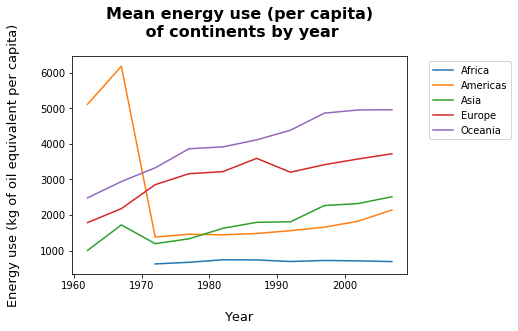

In [42]:
# Return df of mean energy use per year per continent.
# Functions/calculations (e.g. .mean() can be obtained for certain columns as they correspond to other columns using .groupby).
mean_energy_use_by_year_df = energy_continent_values_df.groupby(['continent', 'Year'], as_index=False)['Energy use (kg of oil equivalent per capita)'].mean()

# Pivot df to obtain continents as columns, then create line plot.
mean_energy_use_by_year_df.pivot(index='Year', columns='continent').plot.line()

# Configure figure parameters.
plt.title('Mean energy use (per capita)\n of continents by year', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Energy use (kg of oil equivalent per capita)', fontsize=13, labelpad=20)
plt.xlabel('Year', fontsize=13, labelpad=20)
plt.legend(title=None, bbox_to_anchor=(1.05, 1), loc='upper left', labels=sorted(continents))


To complement the Multiple Comparison of Means - Tukey HSD, the above figure visualises the mean difference in energy usage of continents (per capita) over time.

### PART2 2. Is there a significant difference between Europe and Asia with respect to 'Imports of goods and services (% of GDP)' in the years after 1990? (Stats test needed)

In [43]:
# Return df only with data from the year 1990 onwards.
country_stats_df_1990_onwards = country_stats_df[country_stats_df['Year'] >= 1990]

# Return arrays of European and Asian imports by accessing the relevant columns.
# Drop nans, and convert to list data type for the purposes of performing the T-test.
europe_imports = country_stats_df_1990_onwards[country_stats_df_1990_onwards['continent'] == 'Europe']['Imports of goods and services (% of GDP)'].dropna().tolist()

asia_imports = country_stats_df_1990_onwards[country_stats_df_1990_onwards['continent'] == 'Asia']['Imports of goods and services (% of GDP)'].dropna().tolist()

# Conduct T-test to compare the means of Europe and Asia's imports.
ttest_ind(europe_imports, asia_imports)

Ttest_indResult(statistic=-1.4185256887958828, pvalue=0.1575196932555432)

Above, the T-test indicates there is no significant difference between Asian and European imports of goods and services (% of GDP) in the years since 1990. Below, the figure visualises the way in which the two continents' imports have changed since 1990. Note all countries from each continent are stacked in their respective bar (hover over for specifics), i.e. the continent has the cumulative sum of each country's percentage GDP, hence why bar totals far exceed 100 percent of GDP.

In [84]:
# Return df with either Europe or Asia in the continent column.
europe_asia_1990_onwards_df = country_stats_df_1990_onwards[np.isin(country_stats_df_1990_onwards, ['Europe','Asia']).any(axis=1)].dropna()

# Set grouped bar chart.
fig2 = px.bar(europe_asia_1990_onwards_df, x='Year', y='Imports of goods and services (% of GDP)', color='continent', barmode='group', height=400, width=900, title='European and Asian imports of goods and services (% of GDP) since 1990', hover_data=['Country Name'])
fig2.update_layout(title_font_size=16, title_x=0.5)
fig2.show()

### PART2 3. What is the country (or countries) that has the highest 'Population density (people per sq. km of land area)' across all years? (i.e., which country has the highest average ranking in this category across each time point in the dataset?)

In [45]:
# Return df with continent values that are not nan.
# This seems to be a sensible way of omitting the rows in 'Country Name' that aren't actual countries (e.g. 'European Union').
continent_values_df = country_stats_df[country_stats_df['continent'].notna()]

# Return df of mean population density per country.
# Don't actually need to drop nans - they are ignored by default when calculating mean.
mean_country_pop_density_df = continent_values_df.groupby(['Country Name'], as_index=False)['Population density (people per sq. km of land area)'].mean()
mean_country_pop_density_df

,Country Name,Population density (people per sq. km of land area)
0,Afghanistan,22.613590
1,Albania,97.510288
2,Algeria,9.485763
3,Angola,8.466782
4,Argentina,11.091878
...,...,...
124,Uruguay,17.215263
125,Vietnam,185.296280
126,West Bank and Gaza,475.082143
127,Zambia,9.806755


In [46]:
# Return the row with the largest mean population density.
mean_country_pop_density_df.loc[mean_country_pop_density_df['Population density (people per sq. km of land area)'].idxmax()]


Country Name                                           Singapore
Population density (people per sq. km of land area)       4361.5
Name: 104, dtype: object

In [87]:
# Return df only containing countries with a pop density above 250.00.
# Essentially, here the most densely populated countries are being singled out.
pop_dense_countries_df = mean_country_pop_density_df[mean_country_pop_density_df['Population density (people per sq. km of land area)'] >= 250.00]

# Set bar chart of the most densely populated countries.
fig3 = px.bar(pop_dense_countries_df, x='Country Name', y='Population density (people per sq. km of land area)', title='Countries with largest mean population density')
fig3.update_layout(title_font_size=16, title_x=0.5)


In the above three cells, the mean of each country's population density is calculated. Grouping by 'Country Name' and then calculating the mean of 'Population density (people per sq. km of land area)' returns a DataFrame with the mean over each of the years the country has data for. idxmax() can then be used to identify the largest value in the population density column - Singapore. The DataFrame is then parsed to return only those countries with a mean population density above 250.00, returning just the 11 most densely populated countries (for ease of displaying in a figure). The figure illustrates just how densely populated Singapore is relative to the other countries.

### PART2 4. What country (or countries) has shown the greatest increase in 'Life expectancy at birth, total (years)' since 1962?"


In [48]:
# The above question can be interpreted as either, 'which country has the greatest diff between 1962 and the most recent year', or 'which country has the greatest diff between 1962 and any given peak year' (in theory some may have dropped in subsequent years). The peak year can be determined using max().

# Once again use continent_values_df to return only actual countries.
# Return all columns of df, but only at the index of the highest life expectancy of each country (using idxmax).
# In this way the corresponding year can easily be seen.
max_country_life_expectancy_df = continent_values_df.loc[continent_values_df.groupby(['Country Name'])['Life expectancy at birth, total (years)'].idxmax()]

Are there countries whose greatest life expectancy is not the most recent year in the dataset (2007)?

In [49]:
# Identify any countries whose maximum life expectancy year is not 2007.
max_country_life_expectancy_df[max_country_life_expectancy_df['Year'] != 2007][['Country Name', 'Year', 'Life expectancy at birth, total (years)']]

,Country Name,Year,"Life expectancy at birth, total (years)"
265,Botswana,1987,62.889829
356,Cameroon,1992,53.601951
395,Central African Republic,1987,49.724390
505,Cote d'Ivoire,1987,52.904171
826,Gabon,1992,61.254512
1117,Iraq,1997,68.997049
1205,Kenya,1987,59.598415
1356,Lesotho,1992,59.577659
1642,Montenegro,1992,74.500659
1682,Namibia,1992,61.190000


In [50]:
# Rename life expectancy to 'Peak life expectancy' in the max life expectancy df.
# This is convenient for differentiating between the columns in the df to be merged.
max_country_life_expectancy_df.rename(columns={'Life expectancy at birth, total (years)': 'Peak life expectancy'}, inplace=True)

# Find each country's life expectancy from 1962.
# Conveniently, this df is already defined.
# Merge the two columns into a new df, with 'Country Name' and 'continent' as the common columns.
merge_1962_max_country_life_expectancy_df = pd.merge(df_1962[['Country Name', 'continent', 'Life expectancy at birth, total (years)']], max_country_life_expectancy_df[['Country Name', 'continent', 'Peak life expectancy']])
merge_1962_max_country_life_expectancy_df

,Country Name,continent,"Life expectancy at birth, total (years)",Peak life expectancy
0,Afghanistan,Asia,33.219902,57.833829
1,Albania,Europe,64.162854,76.470293
2,Algeria,Africa,47.045000,72.898366
3,Angola,Africa,33.787585,49.435732
4,Argentina,Americas,65.432610,75.009049
...,...,...,...,...
123,United States,Americas,70.119512,77.987805
124,Uruguay,Americas,68.296634,75.951024
125,Vietnam,Asia,60.410537,74.483854
126,Zambia,Africa,45.853659,52.477146


In [51]:
# Add new column in merged df containing the difference between 1962 life expectancy and peak life expectancy.
merge_1962_max_country_life_expectancy_df['Life expectancy difference'] = merge_1962_max_country_life_expectancy_df['Peak life expectancy'] - merge_1962_max_country_life_expectancy_df['Life expectancy at birth, total (years)']

# Find the maximum difference in life expectancy.
merge_1962_max_country_life_expectancy_df.loc[merge_1962_max_country_life_expectancy_df['Life expectancy difference'].idxmax()]

Country Name                               Tunisia
continent                                   Africa
Life expectancy at birth, total (years)    43.3417
Peak life expectancy                       74.2024
Life expectancy difference                 30.8608
Name: 119, dtype: object

In [86]:
# Set bar chart of country increase in life expectancy.
fig4 = px.bar(merge_1962_max_country_life_expectancy_df, x='Country Name', y='Life expectancy difference', color='continent', width=800, height=500)

# Omitting x axis tick labels due to clutter (these can be seen by hovering over).
fig4.update_xaxes(title='Country', showticklabels=False)
fig4.update_yaxes(title='Net increase in life expectancy (years) since 1962')


In the above six cells, a new DataFrame is first obtained, returning one country per row with its corresponding maximum life expectancy, and the year in which this occurred (obtained using idxmax()). As can be seen, for a number of countries in the dataset, this is not the most recent year (2007). The life expectancy column in the new DataFrame is renamed 'Peak life expectancy', and this is merged with the life expectancy column of the 1962 DataFrame. The difference between peak and 1962 life expectancy is then calculated in a new column, named 'Life expectancy difference', the maximum is found using idxmax(), and the results are displayed in the figure above for all countries. The country with the greatest increase in life expectancy since 1962 is Tunisia, at 30.8608 years, followed closely by Oman at 30.8231 years.  